# Deep learning, part 3

## Imports

In [1]:
from glob import glob
import json
from urllib.request import urlretrieve
from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import (LinearRegression, LogisticRegression, Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split, GridSearchCV)

import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

from torchmetrics import (MeanAbsoluteError, R2Score)
from torchinfo import summary

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import seed_everything

from torchvision.io import read_image
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50, ResNet50_Weights)
from torchvision.transforms import (Resize, Normalize, CenterCrop, ToTensor)

from ISLP import load_data
from ISLP.models import ModelSpec as MS
from ISLP.torch import (SimpleDataModule, SimpleModule, ErrorTracker, rec_num_workers)
from ISLP.torch.imdb import (load_lookup, load_tensor, load_sparse, load_sequential)

seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
Seed set to 0


In [2]:
max_num_workers = rec_num_workers()
max_num_workers

8

In [16]:
def summary_plot(results,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column, color, label) in zip([f'train_{col}_epoch', f'valid_{col}'],
                       ['black', 'red'],[training_legend, valid_legend]):
        results.plot(
            x='epoch',
            y=column,
            label=label,
            marker='o',
            color=color,
            ax=ax, alpha=.8,
        )
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

## Recurrent neural networks

### Sequential models for document classification

#### Load data

In [3]:
(imdb_seq_train, imdb_seq_test) = load_sequential(root='data/IMDB')

In [8]:
(
    (X_train, Y_train),
    (X_valid, Y_valid),
    (X_test, Y_test),
) = load_sparse(
    validation=2000,
    random_state=0,
    root='data/IMDB',
)

#### Data module

In [6]:
imdb_seq_dm = SimpleDataModule(
    imdb_seq_train,
    imdb_seq_test,
    validation=2000,
    batch_size=300,
    num_workers=min(6, max_num_workers),
)

#### LSTM model

In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_size, 32)
        self.lstm = nn.LSTM(
            input_size=32,
            hidden_size=32,
            batch_first=True,
        )
        self.dense = nn.Linear(32, 1)
    def forward(self, x):
        val, (h_n, c_n) = self.lstm(self.embedding(x))
        return torch.flatten(self.dense(val[:,-1]))

Model summary.

In [9]:
X_test.shape[-1]

10003

In [10]:
lstm_model = LSTMModel(X_test.shape[-1])
summary(
    lstm_model,
    input_data=imdb_seq_train.tensors[0][:10],
    col_names=[
        'input_size',
        'output_size',
        'num_params',
    ],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTMModel                                [10, 500]                 [10]                      --
├─Embedding: 1-1                         [10, 500]                 [10, 500, 32]             320,096
├─LSTM: 1-2                              [10, 500, 32]             [10, 500, 32]             8,448
├─Linear: 1-3                            [10, 32]                  [10, 1]                   33
Total params: 328,577
Trainable params: 328,577
Non-trainable params: 0
Total mult-adds (M): 45.44
Input size (MB): 50.00
Forward/backward pass size (MB): 2.56
Params size (MB): 1.31
Estimated Total Size (MB): 53.87

#### Training

In [11]:
lstm_module = SimpleModule.binary_classification(lstm_model)
lstm_logger = CSVLogger('logs', name='IMDB_LSTM')

In [ ]:
lstm_trainer = Trainer(
    deterministic=True,
    max_epochs=20,
    logger=lstm_logger,
    callbacks=[ErrorTracker()],
)
lstm_trainer.fit(lstm_module, fdatamodule=imdb_seq_dm)

#### Test performance

In [13]:
lstm_trainer.test(lstm_module, datamodule=imdb_seq_dm)

Testing: |                                                                                                                                                                            | 0/? [00:00<?, ?it/s]

/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/pyt

Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:01<00:00, 44.49it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.6845999956130981
        test_loss           0.5971724987030029
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5971724987030029, 'test_accuracy': 0.6845999956130981}]

#### Plots

(0.5, 1.0)

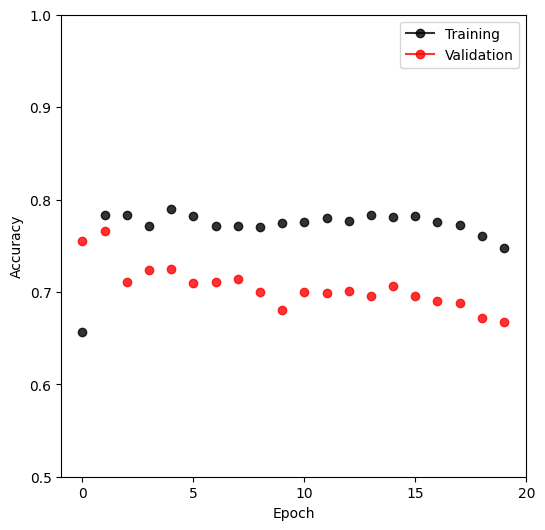

In [17]:
lstm_results = pd.read_csv(lstm_logger.experiment.metrics_file_path)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
summary_plot(
    lstm_results,
    ax, 
    col='accuracy',
    ylabel='Accuracy',
)
ax.set_xticks(np.linspace(0, 20, 5).astype(int))
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5, 1])

#### Cleanup

In [18]:
del(lstm_model,
    lstm_trainer,
    lstm_logger,
    imdb_seq_dm,
    imdb_seq_train,
    imdb_seq_test)

### Time series prediction

#### NYSE data

In [19]:
NYSE = load_data('NYSE')
cols = ['DJ_return', 'log_volume', 'log_volatility']

In [21]:
NYSE[cols].columns

Index(['DJ_return', 'log_volume', 'log_volatility'], dtype='object')

In [22]:
NYSE_s = StandardScaler(
    with_mean=True,
    with_std=True,
).fit_transform(NYSE[cols])

X = pd.DataFrame(NYSE_s, columns=cols, index=NYSE.index)
X.shape

(6051, 3)

In [23]:
for lag in range(1, 6):
    for col in cols:
        newcol = np.zeros(X.shape[0]) * np.nan
        newcol[lag:] = X[col].values[:-lag]
        X.insert(len(X.columns), "{0}_{1}".format(col, lag), newcol)
X.insert(len(X.columns), 'train', NYSE['train'])
X = X.dropna()
X.shape

(6046, 19)

In [24]:
X.head()

,DJ_return,log_volume,log_volatility,DJ_return_1,log_volume_1,log_volatility_1,DJ_return_2,log_volume_2,log_volatility_2,DJ_return_3,log_volume_3,log_volatility_3,DJ_return_4,log_volume_4,log_volatility_4,DJ_return_5,log_volume_5,log_volatility_5,train
date,,,,,,,,,,,,,,,,,,,
1962-12-10,-1.304126,0.605918,-1.366028,0.046340,0.224779,-2.500970,-0.431397,0.935176,-2.366521,0.434813,2.283789,-2.418037,0.905200,1.517291,-2.529058,-0.549823,0.175075,-4.357078,True
1962-12-11,-0.006294,-0.013661,-1.505667,-1.304126,0.605918,-1.366028,0.046340,0.224779,-2.500970,-0.431397,0.935176,-2.366521,0.434813,2.283789,-2.418037,0.905200,1.517291,-2.529058,True
1962-12-12,0.377081,0.042552,-1.551515,-0.006294,-0.013661,-1.505667,-1.304126,0.605918,-1.366028,0.046340,0.224779,-2.500970,-0.431397,0.935176,-2.366521,0.434813,2.283789,-2.418037,True
1962-12-13,-0.411718,-0.419836,-1.597607,0.377081,0.042552,-1.551515,-0.006294,-0.013661,-1.505667,-1.304126,0.605918,-1.366028,0.046340,0.224779,-2.500970,-0.431397,0.935176,-2.366521,True
1962-12-14,0.508785,-0.556065,-1.564386,-0.411718,-0.419836,-1.597607,0.377081,0.042552,-1.551515,-0.006294,-0.013661,-1.505667,-1.304126,0.605918,-1.366028,0.046340,0.224779,-2.500970,True


In [25]:
Y, train = X['log_volume'], X['train']
X = X.drop(columns=['train'] + cols)
X.columns

Index(['DJ_return_1', 'log_volume_1', 'log_volatility_1', 'DJ_return_2',
       'log_volume_2', 'log_volatility_2', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_4', 'log_volume_4', 'log_volatility_4',
       'DJ_return_5', 'log_volume_5', 'log_volatility_5'],
      dtype='object')

#### Linear regression

In [26]:
M = LinearRegression()
M.fit(X[train], Y[train])
M.score(X[~train], Y[~train])

0.4128912938562521

In [28]:
X_day = pd.merge(
    X, 
    pd.get_dummies(NYSE['day_of_week']),
    on='date',
)
X_day.columns

Index(['DJ_return_1', 'log_volume_1', 'log_volatility_1', 'DJ_return_2',
       'log_volume_2', 'log_volatility_2', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_4', 'log_volume_4', 'log_volatility_4',
       'DJ_return_5', 'log_volume_5', 'log_volatility_5', 'mon', 'tues', 'wed',
       'thur', 'fri'],
      dtype='object')

In [29]:
M.fit(X_day[train], Y[train])
M.score(X_day[~train], Y[~train])

0.4595563133053273

#### Setup NYSE data for NN

In [30]:
ordered_cols = []
for lag in range(5,0,-1):
    for col in cols:
        ordered_cols.append('{0}_{1}'.format(col, lag))
X = X.reindex(columns=ordered_cols)
X.columns

Index(['DJ_return_5', 'log_volume_5', 'log_volatility_5', 'DJ_return_4',
       'log_volume_4', 'log_volatility_4', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_2', 'log_volume_2', 'log_volatility_2',
       'DJ_return_1', 'log_volume_1', 'log_volatility_1'],
      dtype='object')

In [31]:
X_rnn = X.to_numpy().reshape((-1,5,3))
X_rnn.shape

(6046, 5, 3)

#### NYSE NN model

In [33]:
class NYSEModel(nn.Module):
    def __init__(self):
        super(NYSEModel, self).__init__()
        self.rnn = nn.RNN(3, 12, batch_first=True)
        self.dense = nn.Linear(12, 1)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        val, h_n = self.rnn(x)
        val = self.dense(self.dropout(val[:,-1]))
        return torch.flatten(val)

In [34]:
nyse_model = NYSEModel()

In [35]:
datasets = []
for mask in [train, ~train]:
    X_rnn_t = torch.tensor(X_rnn[mask].astype(np.float32))
    Y_t = torch.tensor(Y[mask].astype(np.float32))
    datasets.append(TensorDataset(X_rnn_t, Y_t))

/var/folders/cr/qs1xtj294pj5sj1y0055bt6m0000gn/T/ipykernel_3164/1918349690.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_t = torch.tensor(Y[mask].astype(np.float32))
/var/folders/cr/qs1xtj294pj5sj1y0055bt6m0000gn/T/ipykernel_3164/1918349690.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_t = torch.tensor(Y[mask].astype(np.float32))


In [36]:
nyse_train, nyse_test = datasets

Model summary.

In [37]:
summary(
    nyse_model,
    input_data=X_rnn_t,
    col_names=[
        'input_size',
        'output_size',
        'num_params',
    ],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
NYSEModel                                [1770, 5, 3]              [1770]                    --
├─RNN: 1-1                               [1770, 5, 3]              [1770, 5, 12]             204
├─Dropout: 1-2                           [1770, 12]                [1770, 12]                --
├─Linear: 1-3                            [1770, 12]                [1770, 1]                 13
Total params: 217
Trainable params: 217
Non-trainable params: 0
Total mult-adds (M): 1.83
Input size (MB): 0.11
Forward/backward pass size (MB): 0.86
Params size (MB): 0.00
Estimated Total Size (MB): 0.97

#### NYSE data module

In [38]:
nyse_dm = SimpleDataModule(
    nyse_train,
    nyse_test,
    num_workers=min(4, max_num_workers),
    validation=nyse_test,
    batch_size=64,
)

In [39]:
for idx, (x, y) in enumerate(nyse_dm.train_dataloader()):
    out = nyse_model(x)
    print(y.size(), out.size())
    if idx >= 2:
        break

torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])


#### NYSE model training

In [40]:
nyse_optimizer = RMSprop(nyse_model.parameters(), lr=0.001)
nyse_module = SimpleModule.regression(
    nyse_model,
    optimizer=nyse_optimizer,
    metrics={'r2':R2Score()},
)

In [ ]:
nyse_trainer = Trainer(
    deterministic=True,
    max_epochs=200,
    callbacks=[ErrorTracker()],
)
nyse_trainer.fit(nyse_module, datamodule=nyse_dm)

In [42]:
nyse_trainer.test(nyse_module,
                  datamodule=nyse_dm)

Testing: |                                                                                                                                                                            | 0/? [00:00<?, ?it/s]

/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/pyt

Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 351.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6156298518180847
         test_r2            0.4157372713088989
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6156298518180847, 'test_r2': 0.4157372713088989}]

#### Non-linear autoregressive (AR) model

In [43]:
datasets = []
for mask in [train, ~train]:
    X_day_t = torch.tensor(np.asarray(X_day[mask]).astype(np.float32))
    Y_t = torch.tensor(np.asarray(Y[mask]).astype(np.float32))
    datasets.append(TensorDataset(X_day_t, Y_t))

In [44]:
day_train, day_test = datasets

In [45]:
day_dm = SimpleDataModule(
    day_train,
    day_test,
    num_workers=min(4, max_num_workers),
    validation=day_test,
    batch_size=64,
)

In [46]:
class NonLinearARModel(nn.Module):
    def __init__(self):
        super(NonLinearARModel, self).__init__()
        self._forward = nn.Sequential(
            nn.Flatten(),
            nn.Linear(20, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 1),
        )
    def forward(self, x):
        return torch.flatten(self._forward(x))

In [47]:
nl_model = NonLinearARModel()
nl_optimizer = RMSprop(nl_model.parameters(), lr=0.001)
nl_module = SimpleModule.regression(
    nl_model,
    optimizer=nl_optimizer,
    metrics={'r2':R2Score()},
)

In [ ]:
nl_trainer = Trainer(deterministic=True,
                         max_epochs=20,
                         callbacks=[ErrorTracker()])
nl_trainer.fit(nl_module, datamodule=day_dm)

In [49]:
nl_trainer.test(nl_module, datamodule=day_dm) 

Testing: |                                                                                                                                                                            | 0/? [00:00<?, ?it/s]

/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/pyt

Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 599.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5648418664932251
         test_r2            0.46393752098083496
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5648418664932251, 'test_r2': 0.46393752098083496}]